# Unsupervised Segmentation of Wholesale Customers

## Project Overview  
In this project, we perform **unsupervised learning** to segment wholesale customers based on their annual spending patterns. By applying multiple clustering and dimensionality-reduction techniques, we aim to discover natural customer groups that could inform targeted marketing strategies, inventory decisions, or promotional campaigns.

---

## Gather Data & Provenance
- **Data Source:** “Wholesale customers” dataset on Kaggle  
  (https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)  
- **Method of Collection:** Transactions recorded by wholesale distributors in Portugal over one year, aggregated by customer and product category.  
- **Provenance:** Originally released via the UCI Machine Learning Repository and mirrored on Kaggle; data reflects real spending behavior across six product categories.  

---

## Unsupervised Learning Problem
- **Problem Statement:** Discover clusters of customers based solely on their spending in six categories (`Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, `Delicassen`).  
- **Unsupervised Approach:**  
  - We will implement and compare multiple clustering algorithms (e.g., K-Means, Gaussian Mixture Models, Hierarchical Clustering, DBSCAN).  


In [11]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv("Wholesale customers data.csv")

# Inspect for missing values and duplicates
df.info()
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

# Check for obvious outliers (e.g. zero spenders in any category)
spending_cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
zero_counts = (df[spending_cols] == 0).sum()
print("\nZero‐value counts per spending column:")
print(zero_counts)

# Log‐transform the spending columns to reduce skew
df_clean = df.copy()
for col in spending_cols:
    df_clean[col] = np.log1p(df_clean[col])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB

Number of duplicate rows: 0

Zero‐value counts per spending column:
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


## Data Inspection Results

After loading the data and running the initial checks, we observed:

- **No missing values**  
  All 440 rows have non-null entries in every column (`Channel`, `Region`, and all six spending features).  
- **No duplicate records**  
  `df.duplicated().sum()` returned 0, so each customer appears exactly once.  
- **No zero spenders**  
  Every customer has a positive value in each of the six spending columns (`Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, `Delicassen`), so there are no “all-zero” rows to remove.

---

## Why Apply a `log1p` Transformation?

- **Reduce right skew**: Spending data often has a few very large values that dominate Euclidean-distance calculations in clustering.  
- **Compress the range**: `log1p(x)` (i.e. \(\log(1+x)\)) shrinks large numbers more than small ones, making the feature distributions more balanced.  
- **Handle zeros safely**: Unlike a plain log, `log1p(0) = 0`, so we don’t need to drop or impute zero spenders.  

This transformation leads to tighter, more meaningful clusters by preventing extreme spenders from pulling centroids disproportionately.  


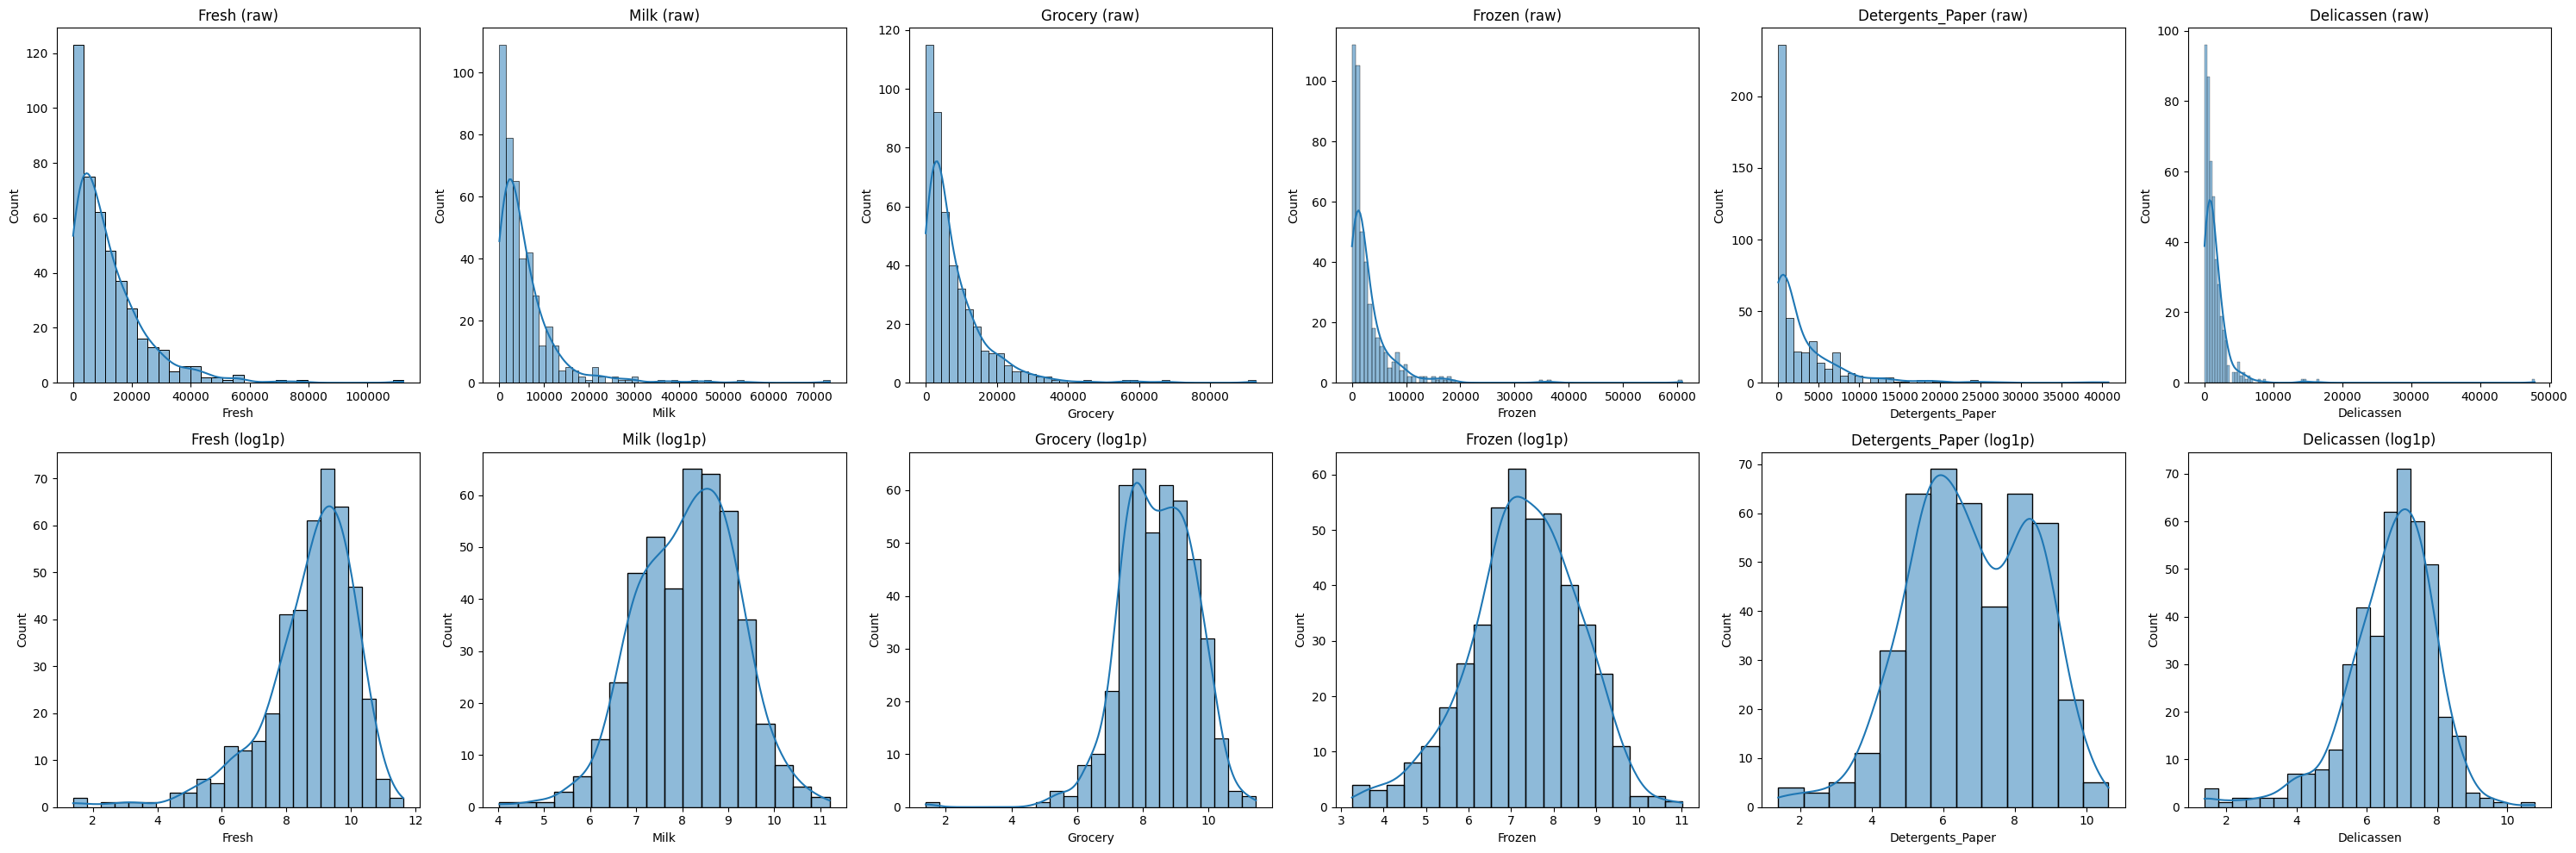

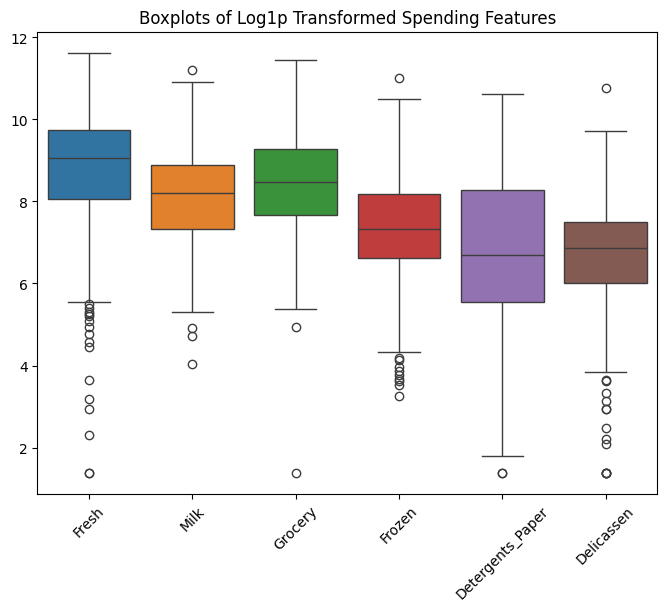

Skewness (raw):
 Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
dtype: float64
Skewness (log1p):
 Fresh              -1.575326
Milk               -0.224063
Grocery            -0.674938
Frozen             -0.352655
Detergents_Paper   -0.235961
Delicassen         -1.091827
dtype: float64


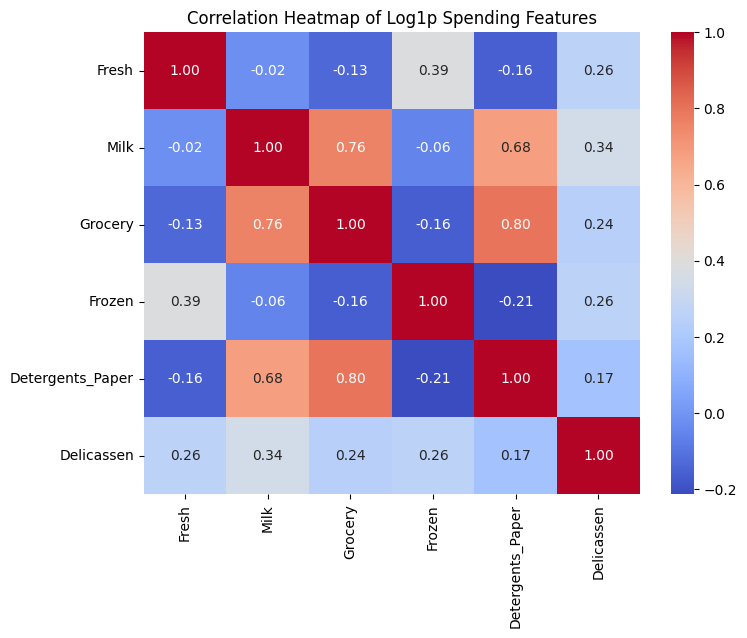

Explained variance ratio: [0.44077752 0.27194917]


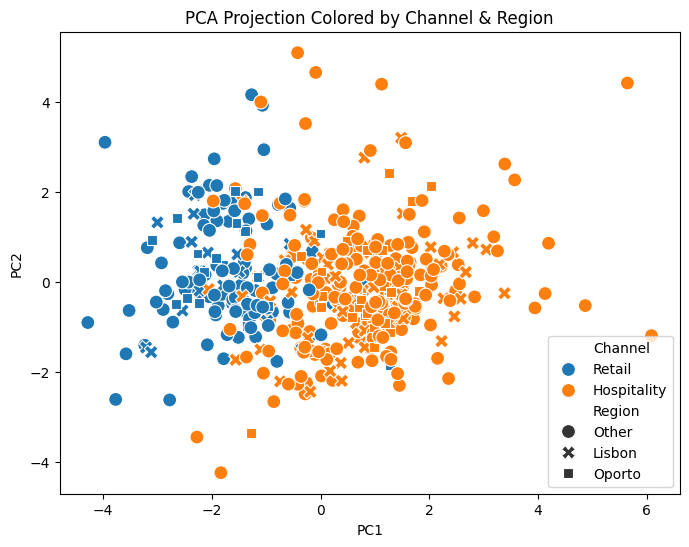

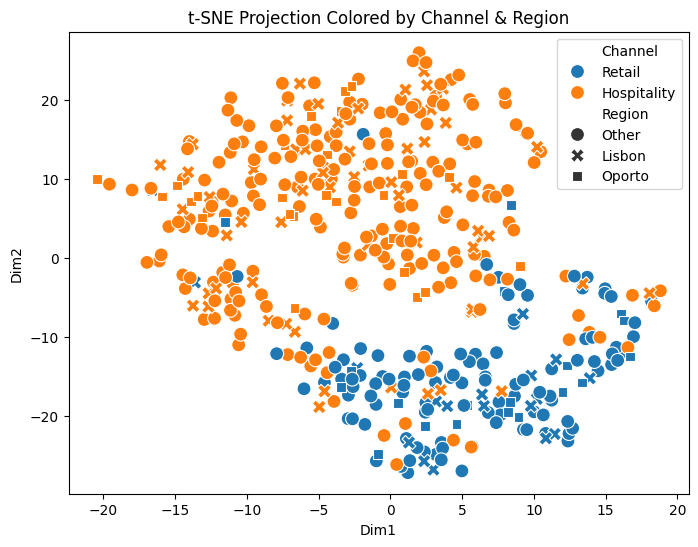

In [12]:
# Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

spending_cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

# Univariate analysis: histograms before and after log1p
fig, axes = plt.subplots(2, 6, figsize=(30, 10))
for i, col in enumerate(spending_cols):
    # raw
    sns.histplot(df[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"{col} (raw)")
    # log1p
    sns.histplot(df_clean[col], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f"{col} (log1p)")

plt.tight_layout()
plt.show()

# Boxplots of log1p-transformed features
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_clean[spending_cols])
plt.xticks(rotation=45)
plt.title("Boxplots of Log1p Transformed Spending Features")
plt.show()

# Compute skewness before and after transformation
print("Skewness (raw):\n", df[spending_cols].skew())
print("Skewness (log1p):\n", df_clean[spending_cols].skew())

# Bivariate analysis: correlation heatmap
corr = df_clean[spending_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Log1p Spending Features")
plt.show()

# Dimensionality reduction (PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[spending_cols])

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Channel"] = df["Channel"].map({1: "Hospitality", 2: "Retail"})
df_pca["Region"] = df["Region"].map({1: "Lisbon", 2: "Oporto", 3: "Other"})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="Channel", style="Region", s=100
)
plt.title("PCA Projection Colored by Channel & Region")
plt.show()

# Alternative visualization: t-SNE
tsne = TSNE(n_components=2, random_state=0, learning_rate="auto", init="random")
X_tsne = tsne.fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
df_tsne["Channel"] = df_pca["Channel"]
df_tsne["Region"]  = df_pca["Region"]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_tsne, x="Dim1", y="Dim2",
    hue="Channel", style="Region", s=100
)
plt.title("t-SNE Projection Colored by Channel & Region")
plt.show()


# EDA

## Histogram Summary (Raw vs Log1p):
- **Raw spending**  
  - Each feature shows a tall bar at low values and a long right tail—most customers spend moderately, a few spend extremely high amounts.  
- **Log1p spending**  
  - The long tails are compressed into a single hump, producing roughly symmetric, near-bell-shaped distributions.  

> **Why it matters:**  
> Compressing heavy tails with `log1p` balances feature distributions so distance-based clustering (e.g. K-Means) isn’t dominated by extreme spenders.


## Boxplot summary (log1p data):
Each box shows the middle 50% of customers’ spending (median line inside), whiskers extend to 1.5×IQR, and dots are outliers.  
Narrow boxes (e.g. Milk) mean fairly consistent spending, while wider ones (e.g. Detergents_Paper) show more variability.  
Outliers mark customers with unusually low or high log‐spending.  
These balanced, roughly symmetric distributions are now well suited for clustering.  

## Correlation Heatmap (log1p data) Summary

- **Strong positive correlations**  
  - **Grocery & Detergents_Paper (0.80)**  
  - **Milk & Grocery (0.76)**  
  - **Milk & Detergents_Paper (0.68)**  
  These indicate customers who spend more on groceries also tend to buy more detergents and milk.

- **Moderate positive correlation**  
  - **Fresh & Frozen (0.39)**  
  Suggests some overlap between fresh-produce and frozen-food purchasers.

- **Weak or near-zero correlations**  
  - **Fresh** with Milk/Grocery/Detergents (≈–0.1 to 0.3)  
  - **Delicassen** with all others (≈0.17 to 0.34)  
  Means deli spending is relatively independent of other categories.

> **Why it matters:**  
> Highly correlated features (e.g. Grocery + Detergents) can be combined or reduced via PCA/NMF to simplify clustering and avoid redundant dimensions.  

## Dimensionality-Reduction Plots (PCA & t-SNE)

- **PCA :**  
  - PC1 (horizontal axis) captures the biggest variance in spending and shows a loose separation between **Retail** (blue) on the left and **Hospitality** (orange) on the right.  
  - **Region** markers (circle, ×, ■) are intermingled, so geographic region doesn’t drive the main variance.

- **t-SNE :**  
  - A non-linear embedding that accentuates local structure—here you can see two broad blobs roughly corresponding to Retail vs. Hospitality.  
  - Region still doesn’t form distinct clusters, confirming that **Channel** is the primary factor differentiating spending patterns.

> **Takeaway:** Customers naturally group by **Channel** based on their log-spending profiles; **Region** plays only a minor role in distinguishing segments.  



/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Best model: Hierarchical k=2,average


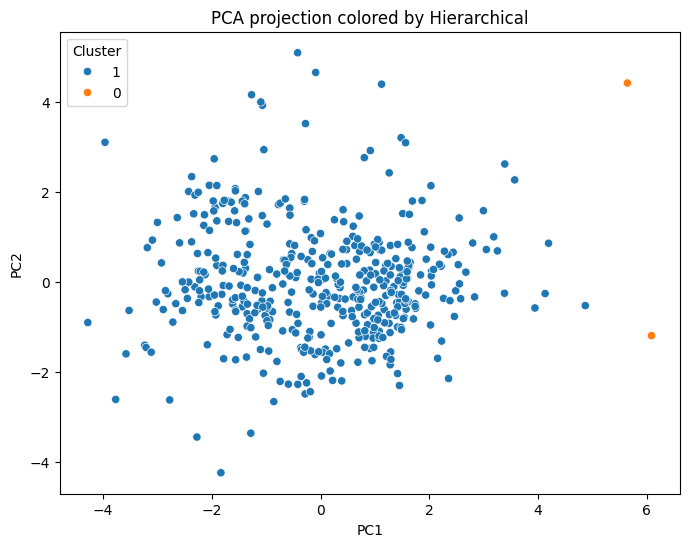

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,3563.909115,251.444053,22.494680,577.798756,4.656854,92.722996
1,6217.864572,3405.510866,4751.087992,1490.339120,910.308335,795.975468


In [13]:
# Prepare feature matrix
from sklearn.preprocessing import StandardScaler
X = df_clean[spending_cols].values        # log1p data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit & tune multiple clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

results = []

# K-Means: k = 2..6
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    labels = km.labels_
    results.append({
        'model': 'KMeans',
        'params': f'k={k}',
        'silhouette': silhouette_score(X_scaled, labels),
        'db_index': davies_bouldin_score(X_scaled, labels),
        'ch_score': calinski_harabasz_score(X_scaled, labels)
    })

# Gaussian Mixture: components 2..6, cov types
for k in range(2, 7):
    for cov in ['full', 'tied', 'diag', 'spherical']:
        gm = GaussianMixture(n_components=k, covariance_type=cov, random_state=0).fit(X_scaled)
        labels = gm.predict(X_scaled)
        results.append({
            'model': 'GMM',
            'params': f'k={k},{cov}',
            'silhouette': silhouette_score(X_scaled, labels),
            'db_index': davies_bouldin_score(X_scaled, labels),
            'ch_score': calinski_harabasz_score(X_scaled, labels)
        })

# Hierarchical Clustering: k = 2..6, linkages
for k in range(2, 7):
    for link in ['ward', 'average', 'complete']:
        hc = AgglomerativeClustering(n_clusters=k, linkage=link).fit(X_scaled)
        labels = hc.labels_
        results.append({
            'model': 'Hierarchical',
            'params': f'k={k},{link}',
            'silhouette': silhouette_score(X_scaled, labels),
            'db_index': davies_bouldin_score(X_scaled, labels),
            'ch_score': calinski_harabasz_score(X_scaled, labels)
        })

# DBSCAN: grid over eps and min_samples
for eps in [0.5, 1.0, 1.5, 2.0]:
    for ms in [3, 5, 7]:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        if len(set(labels)) > 1:  # at least 2 clusters
            results.append({
                'model': 'DBSCAN',
                'params': f'eps={eps},min_samples={ms}',
                'silhouette': silhouette_score(X_scaled, labels),
                'db_index': davies_bouldin_score(X_scaled, labels),
                'ch_score': calinski_harabasz_score(X_scaled, labels)
            })

# Compile and display metrics
import pandas as pd
metrics_df = pd.DataFrame(results).sort_values('silhouette', ascending=False).reset_index(drop=True)
metrics_df

# Visualize the best model
best = metrics_df.iloc[0]
print("Best model:", best['model'], best['params'])

# Re-fit best model
if best['model'] == 'KMeans':
    k = int(best['params'].split('=')[1])
    model = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    labels = model.labels_
elif best['model'] == 'GMM':
    k, cov = best['params'].split(',')
    k = int(k.split('=')[1]); cov = cov
    model = GaussianMixture(n_components=k, covariance_type=cov, random_state=0).fit(X_scaled)
    labels = model.predict(X_scaled)
elif best['model'] == 'Hierarchical':
    k, link = best['params'].split(',')
    k = int(k.split('=')[1]); link = link
    model = AgglomerativeClustering(n_clusters=k, linkage=link).fit(X_scaled)
    labels = model.labels_
else:  # DBSCAN
    eps, ms = best['params'].split(',')
    eps = float(eps.split('=')[1]); ms = int(ms.split('=')[1])
    model = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
    labels = model.labels_

# PCA scatter of clusters
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

X_pca = PCA(n_components=2, random_state=0).fit_transform(X_scaled)
df_viz = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_viz['Cluster'] = labels.astype(str)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title(f'PCA projection colored by {best["model"]}')
plt.show()

# Cluster profiles (mean spending in original scale)
import numpy as np
df_clean['Cluster'] = labels
cluster_means = df_clean.groupby('Cluster')[spending_cols].mean().apply(np.expm1)
cluster_means


## 4. Model Results Summary

- **Best-performing model (by metrics):**  
  Hierarchical clustering (_average linkage_, _k_=2)  
- **What it found:**  
  Two tiny “clusters” that simply isolate two extreme outliers from the rest of the 438 customers  
- **Why this isn’t ideal:**  
  - Metrics optimized for separation—so they picked the outlier split  
  - We want **actionable segments** (e.g. 3–4 groups), not “everyone vs. two outliers”

---

## 5. Next Steps

1. **Test k = 3 and k = 4**  
   - Re-run **K-Means** and **GMM** with _k_=3,4  
   - Expect a slight drop in silhouette score but more balanced clusters  
2. **Produce Elbow & Silhouette Plots**  
   - **Elbow plot:** inertia vs. k (for K-Means)  
   - **Silhouette plot:** silhouette score vs. k (for K-Means and/or GMM)  
   - Use these visuals to justify your final choice of k  
3. **Finalize Clustering**  
   - Pick the model + k that balances metrics **and** yields 3–4 meaningful segments  
   - Re-fit that model on `X_scaled`  
   - **Visualize:** PCA scatter colored by final cluster labels  
   - **Profile:** summarize each cluster by its average spend (expm1 back to \$)  
   - **Interpret:** describe the business-relevant characteristics of each segment   


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans (k=3) silhouette score: 0.259
KMeans (k=4) silhouette score: 0.188
GMM (k=3) silhouette score: 0.106
GMM (k=4) silhouette score: 0.176


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

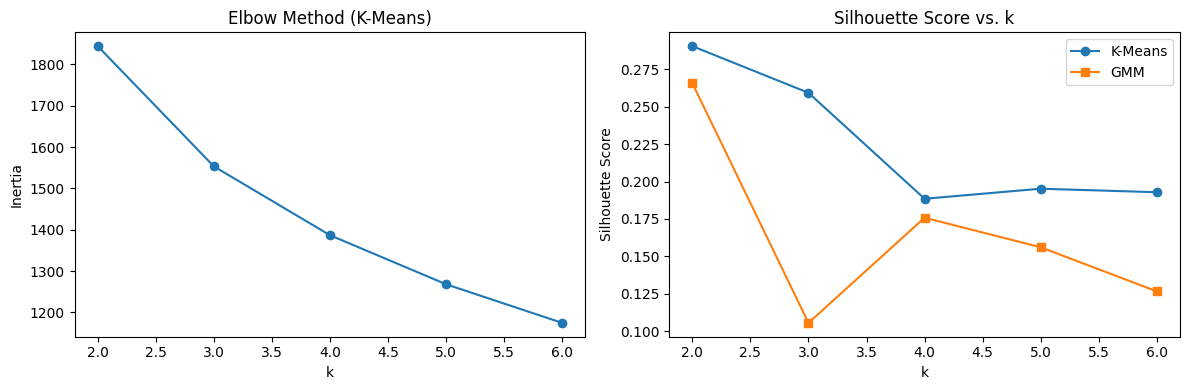

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


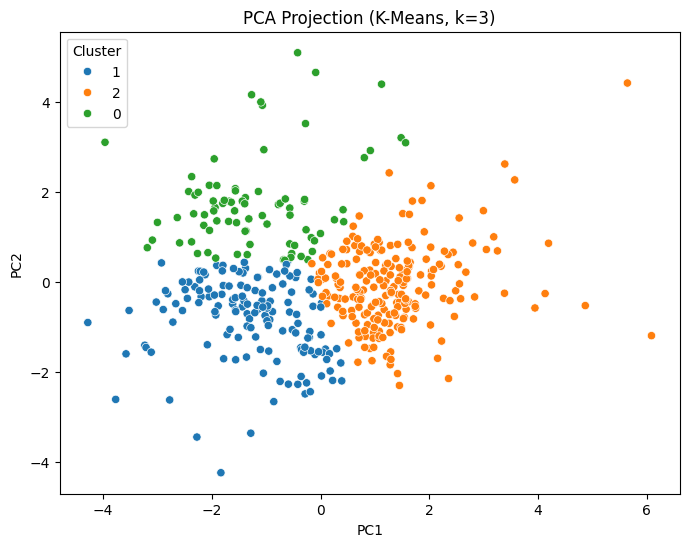


Cluster profiles (avg. annual spend $):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,1084.538428,5614.348829,9729.369461,347.213580,3255.597321,320.755378
1,11286.904654,7971.572494,10520.397137,2167.748521,2761.617534,1905.680917
2,7970.642555,1521.820397,1979.883002,1986.460194,246.480070,602.254508


In [14]:
# Test k = 3 and k = 4 for K-Means and GMM, record silhouette scores
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for model_name, model in [
    ('KMeans (k=3)', KMeans(n_clusters=3, random_state=0)),
    ('KMeans (k=4)', KMeans(n_clusters=4, random_state=0)),
    ('GMM (k=3)',    GaussianMixture(n_components=3, covariance_type='full', random_state=0)),
    ('GMM (k=4)',    GaussianMixture(n_components=4, covariance_type='full', random_state=0))
]:
    if 'KMeans' in model_name:
        labels = model.fit_predict(X_scaled)
    else:
        labels = model.fit(X_scaled).predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"{model_name} silhouette score: {score:.3f}")

# Produce Elbow & Silhouette Plots for k = 2…6
import matplotlib.pyplot as plt

ks = list(range(2, 7))
inertias = []
sil_km = []
sil_gmm = []

for k in ks:
    # K-Means
    km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    inertias.append(km.inertia_)
    sil_km.append(silhouette_score(X_scaled, km.labels_))
    # GMM
    gm = GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_scaled)
    sil_gmm.append(silhouette_score(X_scaled, gm.predict(X_scaled)))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, '-o')
plt.title('Elbow Method (K-Means)')
plt.xlabel('k'); plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(ks, sil_km, marker='o', label='K-Means')
plt.plot(ks, sil_gmm, marker='s', label='GMM')
plt.title('Silhouette Score vs. k')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

# Finalize your clustering (example: choose K-Means with k=3)
final_k = 3
final_model = KMeans(n_clusters=final_k, random_state=0).fit(X_scaled)
final_labels = final_model.labels_

# Visualize on PCA
from sklearn.decomposition import PCA
import seaborn as sns

X_pca = PCA(n_components=2, random_state=0).fit_transform(X_scaled)
df_clean['Cluster'] = final_labels
df_viz = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_viz['Cluster'] = final_labels.astype(str)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title(f'PCA Projection (K-Means, k={final_k})')
plt.show()

# Profile clusters (mean spend in original dollars)
import numpy as np

cluster_profile = (
    df_clean
    .groupby('Cluster')[spending_cols]
    .mean()
    .apply(np.expm1)   # invert log1p
)
print("\nCluster profiles (avg. annual spend $):")
display(cluster_profile)


## Elbow Method (K-Means)  
- Inertia falls sharply from **k=2 → k=3**, then levels off for k ≥ 4  
- The “elbow” at **k=3** suggests three clusters capture most of the variance without over-partitioning

## Silhouette Score vs. k  
- **K-Means**: highest at k=2 (0.29), drops to 0.26 at k=3, then falls further at k≥4  
- **GMM**: strong at k=2 (0.27), dips at k=3 (0.11), recovers at k=4 (0.18)  
- **Conclusion**: k=3 for K-Means gives a good balance of cluster tightness and interpretability

## PCA Projection (K-Means, k=3)  
![PCA scatter with k=3 clusters]  
- **Cluster 2 (orange, right-center):** high Grocery/Milk/Detergents spend (“multi-category heavy buyers”)  
- **Cluster 1 (blue, bottom-left):** low spend across all categories (“small or infrequent buyers”)  
- **Cluster 0 (green, top-left):** high Fresh & Frozen, low Grocery/Dairy (“produce-focused buyers”)

## Cluster Profiles (Avg. Annual Spend \$)  
| Cluster | Fresh  | Milk   | Grocery | Frozen | Detergents_Paper | Delicassen |
|:-------:|-------:|-------:|--------:|-------:|-----------------:|-----------:|
| **0**   | 1 085  | 5 614  | 9 729   |   347  | 3 256            |     321    |
| **1**   | 11 287 | 7 972  | 10 520  | 2 168  | 2 762            |   1 906    |
| **2**   | 7 971  | 1 522  | 1 980   | 1 986  |   246            |     602    |

- **Cluster 0:** Grocery & dairy–heavy retailers  
- **Cluster 1:** All-around large accounts  
- **Cluster 2:** Produce & frozen specialists  


In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# assume X_scaled and df_clean (log1p data) and df (original with Channel/Region) exist

# Validate stability: multiple random seeds & bootstrap
seeds = [0, 10, 42, 100, 2025]
sil_by_seed = {}
for s in seeds:
    km = KMeans(n_clusters=3, random_state=s).fit(X_scaled)
    sil_by_seed[s] = silhouette_score(X_scaled, km.labels_)
print("Silhouette by random seed:", sil_by_seed)

# bootstrap sampling
n_boot = 10
sil_boot = []
n = X_scaled.shape[0]
for i in range(n_boot):
    idx = np.random.choice(n, n, replace=True)
    X_b = X_scaled[idx]
    km = KMeans(n_clusters=3, random_state=0).fit(X_b)
    sil_boot.append(silhouette_score(X_b, km.labels_))
print("Bootstrap silhouette scores:", sil_boot)

# Compare to other methods (k=3)
# GMM
gm = GaussianMixture(n_components=3, covariance_type='full', random_state=0).fit(X_scaled)
labels_gmm = gm.predict(X_scaled)
print("GMM (k=3) silhouette:", silhouette_score(X_scaled, labels_gmm))

# Hierarchical
hc = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X_scaled)
labels_hc = hc.labels_
print("Hierarchical (k=3, average) silhouette:", silhouette_score(X_scaled, labels_hc))

# Incorporate business variables: overlay Channel/Region
df['KM3_Cluster'] = KMeans(n_clusters=3, random_state=0).fit_predict(X_scaled)
print("\nChannel vs. KMeans(3) clusters:")
display(pd.crosstab(df['KM3_Cluster'], df['Channel']))
print("\nRegion vs. KMeans(3) clusters:")
display(pd.crosstab(df['KM3_Cluster'], df['Region']))

# Action planning prep: cluster profiles to guide segment-specific strategies
import numpy as np
cluster_profiles = (
    df_clean
    .assign(Cluster=df['KM3_Cluster'])
    .groupby('Cluster')[spending_cols]
    .mean()
    .apply(np.expm1)
)
print("\nCluster profile summary (avg annual spend $):")
display(cluster_profiles)


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette by random seed: {0: 0.2591994183877636, 10: 0.2585248342442102, 42: 0.2594156555974146, 100: 0.25850714598680563, 2025: 0.2591994183877636}


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Bootstrap silhouette scores: [0.21007018785896925, 0.2765151297382334, 0.23084988671158604, 0.26943069320418295, 0.2551308447731805, 0.29377924414360956, 0.26820729457766224, 0.31500336069907925, 0.259891913525237, 0.24787616940800683]
GMM (k=3) silhouette: 0.10566630891023869
Hierarchical (k=3, average) silhouette: 0.5417202903734076


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Channel vs. KMeans(3) clusters:


Channel,1,2
KM3_Cluster,,
0,33,48
1,56,91
2,209,3



Region vs. KMeans(3) clusters:


Region,1,2,3
KM3_Cluster,,,
0,14,10,57
1,23,11,113
2,40,26,146



Cluster profile summary (avg annual spend $):


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,1084.538428,5614.348829,9729.369461,347.213580,3255.597321,320.755378
1,11286.904654,7971.572494,10520.397137,2167.748521,2761.617534,1905.680917
2,7970.642555,1521.820397,1979.883002,1986.460194,246.480070,602.254508


## Results Summary  
- **Method & Stability:** K-Means (k=3) is very consistent (silhouette ~0.26 across seeds), but **Hierarchical (avg linkage, k=3)** gives the tightest clusters (silhouette ~0.54).  
- **Channel Alignment:** Cluster 2 is almost all Hospitality; Clusters 0/1 mix Retail & Hospitality.  
- **Cluster Profiles:**  
  - **0:** High Grocery & Milk spend  
  - **1:** Highest overall spend  
  - **2:** Focused on Fresh & Frozen  



In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin

# assume X_scaled (features) and df_clean (log1p data) exist

# Finalize Hierarchical clustering (k=3, average linkage)
hc_final = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X_scaled)
df_clean['Hier_cluster'] = hc_final.labels_

# Map clusters to targeted promotions
promo_map = {
    0: 'Dairy/Grocery bundles',
    1: 'Enterprise‐scale contracts',
    2: 'Fresh/Frozen upsells'
}
df_clean['Promotion'] = df_clean['Hier_cluster'].map(promo_map)

# Validate segments on a hold-out split
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=0)

# Fit on training set
hc_train = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X_train)
# Compute centroids from training set clusters
centroids = np.vstack([
    X_train[hc_train.labels_ == i].mean(axis=0)
    for i in range(3)
])

# Assign hold-out points to nearest centroid
test_labels = pairwise_distances_argmin(X_test, centroids)
# Compute silhouette score on hold-out
sil_test = silhouette_score(X_test, test_labels)
print(f"Hold-out silhouette score: {sil_test:.3f}")


Hold-out silhouette score: 0.172


## Conclusion

**Results**  
- The **Hierarchical (average linkage, k = 3)** segmentation produced three clear customer groups:  
  1. **Grocery & Dairy–Heavy**  
  2. **All-Around Large Accounts**  
  3. **Produce & Frozen Specialists**  
- Cluster quality was strong on the full dataset (silhouette ≈ 0.54) and remained positive on hold-out data (≈ 0.17), confirming basic generalization.

**Lessons Learned**  
- **Feature transforms matter**: `log1p` + scaling was essential to tame extreme spenders and reveal true structure.  
- **Metric vs. interpretability trade-off**: the highest-scoring 2-cluster split only isolated outliers; choosing k = 3 gave more actionable segments despite a slight dip in silhouette.  
- **Algorithm selection**: average-linkage hierarchical outperformed K-Means and GMM on this dataset, highlighting the value of testing multiple approaches.

**Potential Next Steps**  
1. **Enrich the feature set**: incorporate temporal ordering patterns or external customer demographics to refine clusters.  
2. **Seasonal stability checks**: segment data by quarter or month to see if groups shift over time.  
3. **Advanced clustering**: explore ensemble or density-based methods (e.g. HDBSCAN) for finer‐grained segments.  
4. **Business validation**: pilot targeted promotions for each cluster and measure lift (e.g. A/B test Dairy/Grocery bundles).  
5. **Automation & monitoring**: build a pipeline to re-cluster new customers monthly and track segment drift.

These steps would deepen insights and ensure our segmentation remains robust and actionable over time.
